# CartPole-v0
"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center."


The following is extracted from: https://github.com/openai/gym/wiki/CartPole-v0

## Observation
Type: Box(4)

| Num |      Observation     |    Min   |   Max   |
|:---:|:--------------------:|:--------:|:-------:|
| 0   | Cart Position        | -2.4     | 2.4     |
| 1   | Cart Velocity        | -Inf     | Inf     |
| 2   | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3   | Pole Velocity At Tip | -Inf     | Inf     |

## Action
Type: Discrete(2)
| Num |      Observation     |    Min   |   Max   |
|:---:|:--------------------:|:--------:|:-------:|
| 0   | Cart Position        | -2.4     | 2.4     |
| 1   | Cart Velocity        | -Inf     | Inf     |
| 2   | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3   | Pole Velocity At Tip | -Inf     | Inf     |
Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it.

## Reward
Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.


## Starting State
All observations are assigned a uniform random value between ±0.05.

## Episode Termination
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200 (500 for v1).

## Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.


https://gym.openai.com/envs/CartPole-v0/ &  https://gym.openai.com/docs/ :

Loop: Each timestep, the agent chooses an action, the environment returns an observation and a reward. The process starts by calling reset() which returns an intitial observation:
    "on each episode, and at every step, an action is chosen based on the current state and a policy based on the action-value function Q. After taking the action, we receive a reward and arrive at the next state. This information is used to update the action-value function, and, after doing so, we make the next state our current state and follow through until we reach the final state of the final episode." - https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d

**Step** returns 4 values:
1. Observation is an environment specific object representing your observation of the environment e.g. pixel data from camera or board state in boardgame. 
2. Reward is a float. It is the amout of reward achieved by the prior action. The goal is to increase total reward. The reward scale varies between environments.
3. Done is a boolean. Whether it is time to reset the environment. Most tasks are divided into episodes which terminate when done.
4. Info (dict) provides diagnostic information for debugging.

Every **environment** comes with an action_space and an observation_space, which describe the format of valid actions and observations. The Discrete space allows a fixed range of non-negative numbers e.g. valid **actions** are either 0 or 1.  The Box space represents and n-dimensional box so valid **observations** will be an array of 4 numbers.

In CartPole, one of the actions applies force to the left and one applies force to the right

"Since this [Q learning] algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. " - https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d 

The action-value function must be updated at every step of learning. The values for the pairs of state visited and action taken are updated. 
 
See also: https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df
Read https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d with https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

###### Goal: The way to choose the best action for every state in the environment.
- Gym presets the reward ie cannot change reward to solve these problems. 
- You can change how the q-table is populated. You can change how the Q-table is calculated on each step. e.g. Keep track of the reward for each step and long term. Alter learning rate and discount rate.



This whole file's source code is copied from: https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

In [47]:
import gym
from gym import wrappers
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Buckets  
***Group several values of each of the variables into the same “bucket” and treat them as similar state***

Since the Q Learning "algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. 

The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. 

To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. 

The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively.

This discretize_state(obs) function takes an observation from the environment and transforms it into something more manageable. By combining states that are very similar and treating it as the same, we have reduced the state space and made the Q-table smaller and easier to fill."

-https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d

https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d

"Since this algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively."

https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
    """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the buckets list.
        """

In [48]:
"""
Base code taken from: 
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
"""

class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6), #buckets: the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state
                 num_episodes=500, min_lr=0.1, #min-lr is the learning rate. #Between 0 and 1. How quickly the agent abandons the previous value in the Q table for the new value. 0: Agent learns nothing and only uses prior knowledge. 1: Agent considers only the most recent information.
                 min_epsilon=0.1, discount=1.0, decay=25): #min epsilon is the exploration rate. #1: Guaranteed that agent starts the game by 100% exploring the environment #0: Agent does not explore at all. Agent only exploits (chooses actions to get max points)
                                                            #discount is the discount rate. Determines the importance of future rewards. 0 agent is short sighted and sees only current reqards. Appoaching 1, the agent strives for long term rewards.
                                                            #decay is the  exploration_decay_rate
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('CartPole-v0')
        
        # This is the action-value function being initialized to 0's
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        
        #
        self.steps = np.zeros(self.num_episodes)
        
        

    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the buckets list.
        """
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i])) 
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        """
        Implementation of e-greedy algorithm. Returns an action (0 or 1).
        
        Input:
        state (tuple): Tuple containing 4 non-negative integers within
                       the range of the buckets.
        
        Output:
        (int) Returns either 0 or 1
        """
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
        
    def get_action(self, state, e):
        """
        Another policy based on the Q-table. Slight variation from 
        e-greedy. It assumes the state fed hasn't been discretized and 
        returns a vector with probabilities for each action.
        
        Input: 
        state (tuple): Contains the 4 floats used to describe
                       the current state of the environment.
        e (int): Denotes the episode at which the agent is supposed
                 to be, helping balance exploration and exploitation.
                 
        Output:
        action_vector (numpy array): Vector containing the probability
                                     of each action being chosen at the
                                     current state.
        """
        obs = self.discretize_state(state)
        action_vector = self.Q_table[obs]
        epsilon = self.get_epsilon(e)
        action_vector = self.normalize(action_vector, epsilon)
        return action_vector

    def normalize(self, action_vector, epsilon):
        """
        Returns a vector with components adding to 1. Ensures 
        
        Input:
        action_vector (numpy array): Contains expected values for each
                                     action at current state from Q-table.
        epsilon (float): Chances that the e-greedy algorithm would 
                         choose an action at random. With this pol
        
        Output:
        new_vector (numpy array): Vector containing the probability
                                  of each action being chosen at the
                                  current state.
        """
        
        total = sum(action_vector)
        new_vector = (1-epsilon)*action_vector/(total)
        new_vector += epsilon/2.0
        return new_vector

    def update_q(self, state, action, reward, new_state):
        """
        Updates Q-table using the rule as described by Sutton and Barto in
        Reinforcement Learning.
        """
        self.Q_table[state][action] += (self.learning_rate * 
                                        (reward 
                                         + self.discount * np.max(self.Q_table[new_state]) 
                                         - self.Q_table[state][action]))

    def get_epsilon(self, t):
        """Gets value for epsilon. It declines as we advance in episodes."""
        # Ensures that there's almost at least a min_epsilon chance of randomly exploring
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        """
        Trains agent making it go through the environment and choose actions
        through an e-greedy policy and updating values for its Q-table. The 
        agent is trained by default for 500 episodes with a declining 
        learning rate and epsilon values that with the default values,
        reach the minimum after 198 episodes.
        """
        # Looping for each episode in the range
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset())

            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False
            
            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # Update Q(S,A)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                
                # We break out of the loop when done is False which is
                # a terminal state.
        print('Finished training!')
    
    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(range(len(self.steps)),self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")
        

    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'CartPole-v0')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state   
        return t
    

Finished training!


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


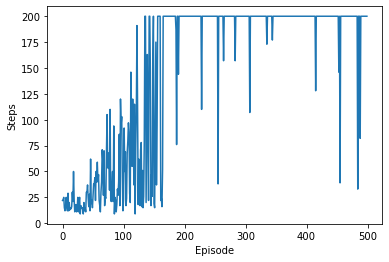

330 episodes were successfully completed.


In [49]:
def load_q_learning():
    agent = CartPoleQAgent()
    agent.train()
    agent.plot_learning()
    return agent
    
agent = load_q_learning()